In [2]:
%reset -f
import time
import numpy as np
import sympy as sp
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.interpolate as interpolate
from scipy.integrate import solve_bvp

# from tueplots.bundles import probnum2025
# plt.rcParams.update(probnum2025())


The central idea is to start from the $\alpha$ and $\psi$ of Schwarzschild, and gradually add multiple $\delta \rho$'s to it to obtain the TOV solution

### 0. Solutions to the TOV-Equations and Source/Matter Terms

In [3]:
# Load the variables from tov-final
r_o   = 1.0e+3          # outer radius (maximum radius)
r_c   = 1.0e-1          # central radius (minimum radius)
P_c   = 1.0e-1          # central pressure (maximal pressure)

# Specify and load the file
filename    = f'../../data/tov_{round(np.log10(r_o)):+}{round(np.log10(r_c)):+}{round(np.log10(P_c)):+}.npy'
loaded_data = np.load(filename)

# Unpack the values
r, m, P, rho, R, alpha, psi = loaded_data

# Define polytropic constants (using c = G = 1 units for simplicity)
K     = 100    # Polytropic constant
Gamma = 2      # Polytropic exponent

# Polytropic Equation of State (EOS)
def pressure(rho):
    return K * rho**Gamma

downsample_factor = 2000
m     = m[::downsample_factor]
P     = P[::downsample_factor]
rho   = rho[::downsample_factor]
R     = R[::downsample_factor]
alpha = alpha[::downsample_factor]
psi   = psi[::downsample_factor]

# Express the source/matter terms
W  = 1                                         # Lorentz factor
v  = np.zeros_like(rho)                        # radial velocity

E  = rho
Sr = rho * (1 + P/rho) * W**2 * v
S  = rho * (1 + P/rho) * W**2 * v**2 + 3 * P

psi_ground_truth = psi

## 1. Application of a perturbation to the density

In [4]:
# Definitions
iteration_steps = 5000

# Perturbation parameters
center_value  = 0.3        # Center value
sigma         = 1.0e-1     # Width of the full Gaussian
amplitude     = 1.0e-2     # Scale factor

# Construction of the perturbation
center_index  = np.argmin(np.abs(R - center_value))
R_centered    = (R - R[center_index])/R[center_index]
gaussian      = amplitude * np.exp(-((R - R[center_index]) ** 2) / (2 * sigma**2))
density_perturbation  = gaussian * R_centered


#### Linear Perturbations

In [5]:
# Initialize the density and density perturbation
density = np.zeros((len(density_perturbation), iteration_steps+1))
density[:, 0] = rho
density_perturbations = np.zeros((len(density_perturbation), iteration_steps))

max_number_of_perturbations_from_original = 250
density_perturbation = max_number_of_perturbations_from_original / iteration_steps * density_perturbation

for i in range(1, iteration_steps+1):
    if i < iteration_steps//2 + 1:
        density_perturbations[:,i-1] = density_perturbation
    else:
        density_perturbations[:,i-1] = - density_perturbation

    density[:, i] = density[:, i-1] + density_perturbations[:, i-1]

#### Sinusoidal perturbation

In [6]:
# Sinusoidal envelope for time-varying transitions
t = np.linspace(0.1, np.pi/2, iteration_steps//2)
temporal_envelope = np.sin(t)

# Initialize density and density perturbation
density = np.zeros((len(density_perturbation), iteration_steps+1))
density[:, 0] = rho
density_perturbations = np.zeros((len(density_perturbation), iteration_steps))

# Apply time-dependent perturbations (asymmetrical in time)
for i in range(iteration_steps//2):
    envelope_value = temporal_envelope[i]
    perturb = density_perturbation * envelope_value
    density_perturbations[:, i] = perturb
    density[:, i+1] = density[:, i] + perturb

for i in range(iteration_steps//2):
    envelope_value = temporal_envelope[i]
    perturb = -density_perturbation * envelope_value
    density_perturbations[:, i+iteration_steps//2] = perturb
    density[:, i+iteration_steps//2+1] = density[:, i+iteration_steps//2] + perturb


### 2. Problem Definition

Given the perturbation on the density, the vector equations are trivially zero.

We focus on the the first scalar ODE to solve is:

\begin{equation}
\left(\nabla^{2} + S_{1} / \psi^{2} + 7 S_{7} / \psi^{8} \right) \delta \psi = \delta S_{1} / \psi + \delta S_{7} / \psi^{7}
\end{equation}
in which 
\begin{align}
    S_1   &= -2 \pi \rho_{perturbed} \\ 
    \delta S_1 &= - 2 \pi \delta \rho \\
    S_7   &= 0 \\
    \delta S_7 &= 0
\end{align}

We can define $\tilde{k}^{2}_{\psi} = -S_{1} /  \psi^{2} - 7 S_{7} / \psi^{8}$ such that the scalar ODE becomes:
\begin{equation}
    \left(\nabla^{2} - \tilde{k}^{2}_{\psi} \right) \ \delta \psi = \delta S_{1} / \psi + \delta S_{7} / \psi^{7}
\end{equation}
Only considering nonzero functions and defining $k^2_{\psi} = - S_{1} / \psi^{2}$ yields:
\begin{equation}
    \left(\nabla^{2} - k^{2}_{\psi} \right) \ \delta \psi = \delta S_{1} / \psi
\end{equation}
The boundary conditions are:
\begin{align}
    \frac{d \delta \psi}{dr}(0) &= 0 \\
    \delta \psi(R) &= 0
\end{align}

### 3. Baseline Classical Numerical Solution

We can also directly solve the equation in $f(r)$:
\begin{align}
    \bigg( \partial_{r}^{2} + \frac{2}{r} \partial_r - k^2(r) \bigg) f(r) = b(r)
\end{align}
with the boundary conditions:
\begin{align}
    \frac{df}{dr}(0) &= 0 \\
    f(R) &= 0
\end{align}

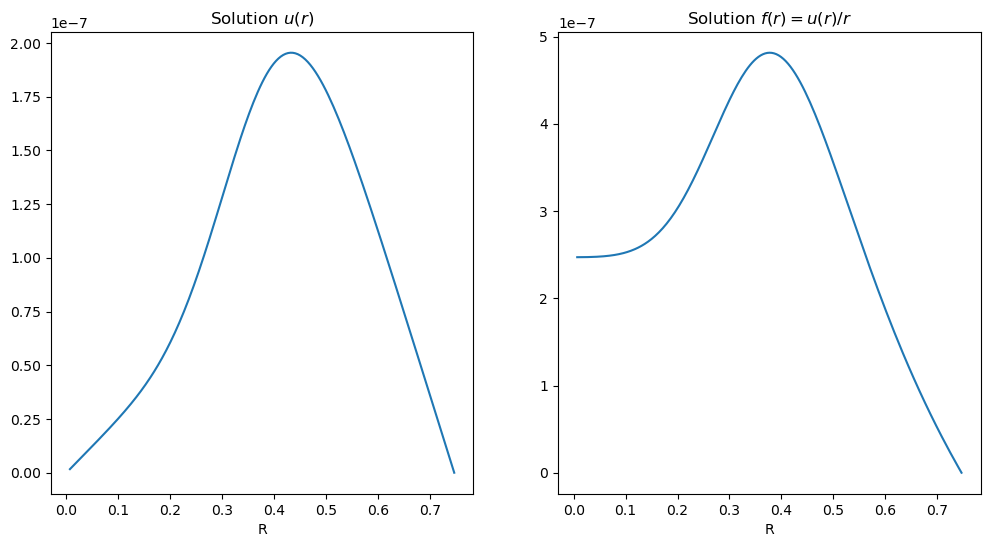

In [7]:
# Definition of the ODE
S1           = - 2*np.pi*density[:,0]
dS1          = -2*np.pi*density_perturbations[:,0]
k_squared1   = - S1/psi**(2)
source_term1 = dS1 / psi

# Interpolate the numerically determined functions
k_squared1_interp   = interpolate.interp1d(R, k_squared1,   kind='cubic', bounds_error=False, fill_value='extrapolate')
source_term1_interp = interpolate.interp1d(R, source_term1, kind='cubic', bounds_error=False, fill_value='extrapolate')

# Conversion of the 2nd order ODE to a 1st order system of ODEs defining a state vector y such that y[0] = u, and y[1] = du/dr
def fun(r, y):
    u   = y[0]
    du  = y[1]
    ddu = k_squared1_interp(r) * u + r * source_term1_interp(r)
    return np.vstack((du, ddu))

# Define the boundary conditions:
def bc(ya, yb):
    r0 = r_domain[0]  # first grid point, e.g. 0.005
    return np.array([ya[0] - r0 * ya[1],  # inner BC: u(r0) - r0*u'(r0)=0
                     yb[0]             ])  # outer BC: u(R) = 0

# Define the domain
r_domain = R

# Initial guess for solution y: two components, u and du/dr
y_guess  = np.zeros((2, r_domain.size))

# Solve BVP
sol = solve_bvp(fun, bc, r_domain, y_guess)

# Recover f(r) = u(r)/r
u = sol.y[0]
f = u / r_domain

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(R, u)
ax[0].set_xlabel('R');
ax[0].set_title(r"Solution $u(r)$")

ax[1].plot(R, f);
ax[1].set_xlabel('R');
ax[1].set_title(r"Solution $f(r) = u(r)/r$");


### 4. Probabilistic Numerical Solution

#### 4.1 A Single Time-Step

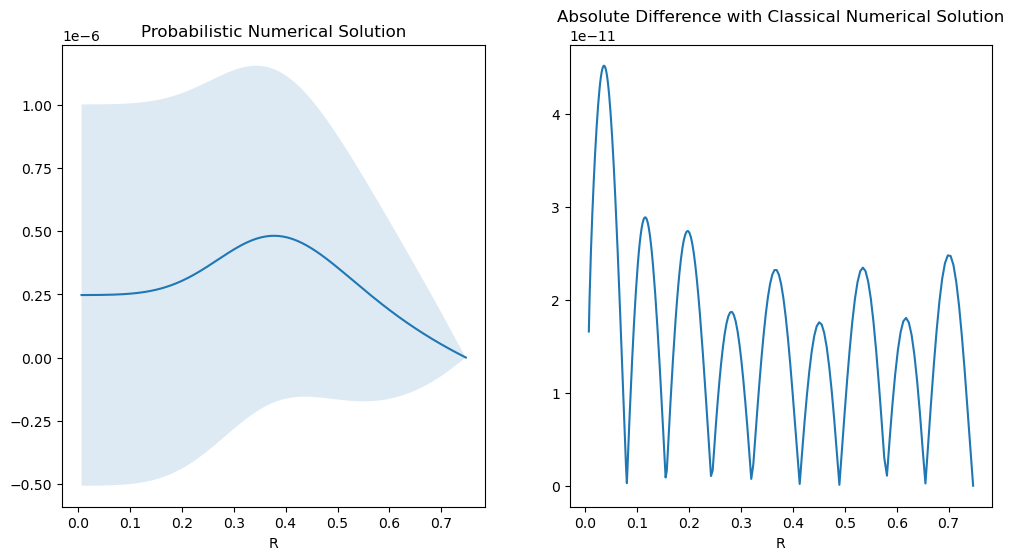

In [9]:
# Function definitions 
def construct_design_matrix(S1, dS1, r_domain, basis_func, laplacian, psi, N):
    # Definition of k_squared and the source term
    k_squared   = - S1/psi**(2)
    source_term = dS1 / psi

    # Lambdify the basis functions
    basis_func_lambd = sp.lambdify((r, n, R_max), basis_func)
    
    # Initialization of the design matrix
    design_matrix = np.zeros((len(r_domain), N))
    basis_func_matrix = np.zeros((len(r_domain), N))

    for i in range(1, N):
        # Define the first part of the operator
        operator_part_1 = sp.lambdify((r, n, R_max), sp.simplify(laplacian(r, basis_func)))(r_domain, i, max(r_domain))
        operator_part_2 = -k_squared*basis_func_lambd(r_domain, i, max(r_domain))
    
        design_matrix[:,i] = operator_part_1 + operator_part_2
        basis_func_matrix[:,i] = basis_func_lambd(r_domain, i, max(r_domain))

    return basis_func_matrix, design_matrix, source_term


def construct_design_matrix_fast(S1, dS1, r_domain, basis_func_lamb, operator_1_lamb, psi, N):
    # Definition of k_squared and the source term
    k_squared   = - S1/psi**(2)
    source_term = dS1 / psi
    
    # Initialization of the design matrix
    design_matrix = np.zeros((len(r_domain), N))
    basis_func_matrix = np.zeros((len(r_domain), N))
    
    for i in range(1, N):
        # Define the first part of the operator
        operator_part_1 = operator_1_lamb(r_domain, i, max(r_domain))
        operator_part_2 = -k_squared*basis_func_lambd(r_domain, i, max(r_domain))
    
        design_matrix[:,i] = operator_part_1 + operator_part_2
        basis_func_matrix[:,i] = basis_func_lambd(r_domain, i, max(r_domain))

    return basis_func_matrix, design_matrix, source_term

    
def solve_ode(basis_func_matrix, design_matrix, y, S, L):
    # Define the (inverse) squared lambda and sigma matrices
    Sneg2 = np.linalg.matrix_power(S, -2)
    Lneg2 = np.linalg.matrix_power(L, -2)
    
    # Reformulate the problem into an A @ w = b problem, and solve the least-squares (in the "classical perspective")
    A = design_matrix.T @ Sneg2 @ design_matrix + Lneg2
    b = design_matrix.T @ Sneg2 @ y
    
    # Solve the system
    w = np.linalg.solve(A, b)
    
    # Computation of the source function mean
    source_func_mean_primal = design_matrix @ w
    source_func_mean_primal = np.squeeze(source_func_mean_primal)
    
    # Computation of the source function variance
    v = np.linalg.solve(A, design_matrix.T)
    source_func_variance_primal = design_matrix @ v
    source_func_variance_primal = np.diag(source_func_variance_primal)
    
    # Computation of the solution mean
    solution_mean_primal = basis_func_matrix @ w
    solution_mean_primal = np.squeeze(solution_mean_primal)
    
    # Computation of the solution variance
    v = np.linalg.solve(A, basis_func_matrix.T)
    solution_variance_primal = basis_func_matrix @ v
    solution_variance_primal = np.diag(solution_variance_primal)

    return solution_mean_primal, solution_variance_primal, solution_variance_primal, w, v

# Definition of S1 and dS1
S1           = -2*np.pi*density[:,0]
dS1          = -2*np.pi*density_perturbations[:,0]

# Symbol nomenclature
r = sp.symbols('r')
n = sp.symbols('n')
R_max = sp.symbols('R_max')

# Define the domain
r_domain = R

# Define the basis functions as the eigen functions
basis_func = sp.sqrt(2) * sp.sin(n * sp.pi * r / R_max) / (r * n**2)
basis_func_lambd = sp.lambdify((r, n, R_max), basis_func)

# Specificy the problem as: L f = g
laplacian   = lambda r, func: sp.diff(func, r, 2) + 2 / r * sp.diff(func, r)
operator_1_lamb = sp.lambdify((r, n, R_max), sp.simplify(laplacian(r, basis_func)))

N = 10
basis_func_matrix, design_matrix, source_term = construct_design_matrix(S1, dS1, r_domain, basis_func, laplacian, psi, N)

# Solve the ODE
S = 1.0e-4*np.identity(len(r_domain))
L = 1.0e-3*np.identity(N)
solution_mean_primal, solution_variance_primal, _, w, v = solve_ode(basis_func_matrix, design_matrix, source_term, S, L)


fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(R, solution_mean_primal)
ax[0].fill_between(R, solution_mean_primal - np.sqrt(solution_variance_primal), solution_mean_primal + np.sqrt(solution_variance_primal), alpha=0.15)
ax[0].set_xlabel('R');
ax[0].set_title(r"Probabilistic Numerical Solution")

ax[1].plot(R, np.abs(solution_mean_primal - f));
ax[1].set_xlabel('R');
ax[1].set_title(r"Absolute Difference with Classical Numerical Solution");

#### 4.2 Several Time-Steps
This requires uncertainty propagation. In time step $n$, we obtain $\psi^{(n)}$ as $\psi^{(n-1)} + \delta \psi^{(n-1)}$. Given that:
\begin{align}
    \psi^{(n-1)} &\sim \mathcal{N}(\mu_{\psi, n-1}, \Sigma_{\psi, n-1}) \\
    \delta \psi^{(n-1)} &\sim \mathcal{N}(\mu_{\delta \psi, n-1}, \Sigma_{\delta \psi, n-1}) \\
\end{align}
Such that $\psi^n = \psi^{(n-1)} + \delta \psi^{(n-1)} \sim \mathcal{N}(\mu_{\psi, n}, \Sigma_{\psi, n})$ in which:
\begin{align}
    \mu_{\psi, n} &= \mu_{\psi, n-1} + \mu_{\delta \psi, n-1} \\
     \Sigma_{\psi, n} &= \Sigma_{\psi, n-1} + \Sigma_{\delta \psi, n-1}
\end{align}
Based on the equations above, we require a distribution for $\frac{1}{\psi^{(n)}}$ and $\frac{1}{(\psi^{(n)})^{2}}$. Although these distributions are no longer Gaussian, we can approximate the distributions as Gaussians for the uncertainty quantification. In general, when the $\psi \sim \mathcal{N}(m, \Sigma)$, and we want to approximate the distribution of $f(x)$ in which $f$ is a differentiable function with Jacobian matrix $J_f$ evaluated at $m$, that is: $J_f(m)_{ij} = \frac{\partial f_i}{\partial \psi_j} \bigg\rvert_{\psi = m}$ we obtain the following mean and covariance:
\begin{align}
    \mathbb{E}\lbrack f(\psi) \rbrack &\approx f(m) \\
    Cov(f(\psi)) &\approx J_f(m) \Sigma J_f(m)^T
\end{align}

For the source function, $\frac{1}{\psi}$, this yields:
\begin{align}
    \mathbb{E}\lbrack \frac{1}{\psi}_i \rbrack &\approx \frac{1}{m_i}
\end{align}
for the covariance, the formula above applies, where $(J_f(m))_{ii} = - \frac{1}{m_i^2}$


00%|██████████████████████████████████████| 5000/5000 [00:32<00:00, 155.78it/s]

Text(0.5, 1.0, '$\\delta \\psi$ in Each Timestep')

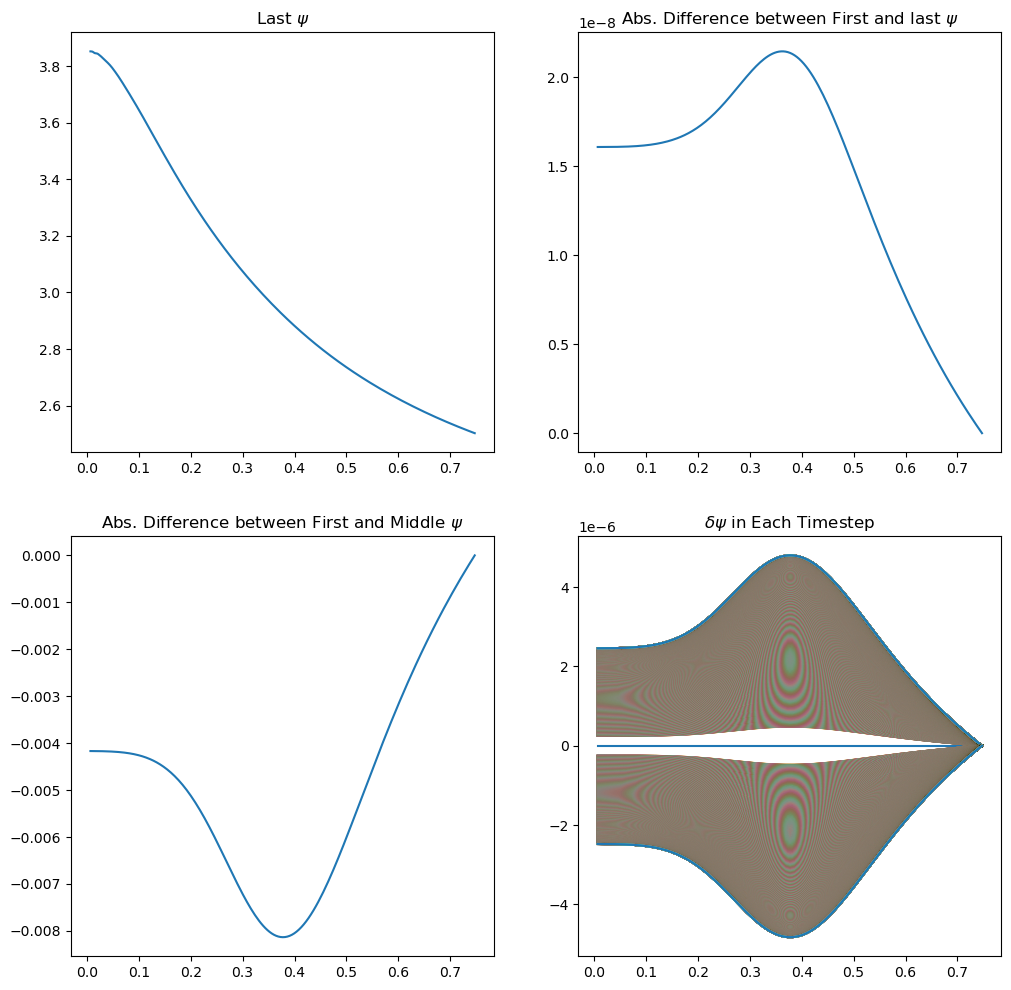

In [31]:
psi_mean_storage       = np.zeros((len(psi), iteration_steps+1))
psi_var_storage        = np.zeros((len(psi), len(psi), iteration_steps+1))
delta_psi_mean_storage = np.zeros((len(psi), iteration_steps+1))
delta_psi_var_storage  = np.zeros((len(psi), len(psi), iteration_steps+1))

# Initial psi
M = m[-1]
rs = 2*M
psi_init = psi_ground_truth

# Parameters
S = 1.0e-4*np.identity(len(r_domain))
L = 1.0e-4*np.identity(N)

# Storage
psi_mean_storage[:, 0] = psi_init
delta_psi_mean_storage[:, 0] = np.zeros_like(psi)
delta_psi_var_storage[:, :, 0] = S

for i in tqdm(range(iteration_steps)):
        
    # Define S1 and dS1
    S1  = -2*np.pi*density[:, i]
    dS1 = -2*np.pi*density_perturbations[:, i]

    # Define the ODE to be solved
    basis_func_matrix, design_matrix, source_term = construct_design_matrix_fast(S1, dS1, r_domain, basis_func_lambd, operator_1_lamb, psi_mean_storage[:, i], N)

    # Solve the ODE
    delta_psi_mean, delta_psi_var, _, _, _ = solve_ode(basis_func_matrix, design_matrix, source_term, S, L)

    # Store 
    delta_psi_mean_storage[:, i+1] = delta_psi_mean
    delta_psi_var_storage[:, :, i+1] = delta_psi_var

    # Update psi mean and covariance
    psi_mean_storage[:, i+1]   = psi_mean_storage[:, i] + delta_psi_mean
    psi_var_storage[:, :, i+1] = psi_var_storage[:, :, i] + delta_psi_var

    # Update the covariance in the right-hand side
    # J = np.diag(-(1/(psi_mean_storage[:, i+1]**2)))
    
    # S = J @ S @ J.T

# Visualization
fig, ax = plt.subplots(2,2, figsize=(12, 12))
ax[0, 0].plot(r_domain, psi_mean_storage[:,-1])
ax[0, 0].set_title(r"Last $\psi$")

ax[0, 1].plot(r_domain, np.abs(psi_mean_storage[:,0] - psi_mean_storage[:,-1]))
ax[0, 1].set_title(r"Abs. Difference between First and last $\psi$")

ax[1, 0].plot(r_domain, psi_mean_storage[:,0] - psi_mean_storage[:,iteration_steps//2])
ax[1, 0].set_title(r"Abs. Difference between First and Middle $\psi$")

ax[1, 1].plot(r_domain,  delta_psi_mean_storage);
ax[1, 1].set_title(r"$\delta \psi$ in Each Timestep")

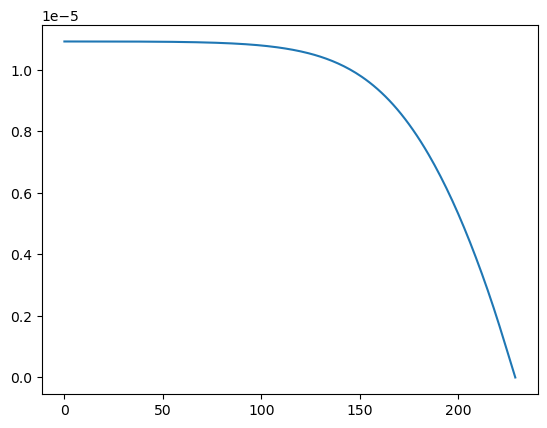

In [26]:
plt.plot(np.sqrt(np.diag(psi_var_storage[:,:,210])))